# Black-Scholes - Monte Carlo Simulation - No dividends

> Author: Gustavo Monteiro de Athayde  
> Monitor: Sylvio Ximenez de Azevedo Neto - <<sylvioxan@insper.edu.br>>  
> Date: 15/03/2025



In [1]:
# dependencies
from IPython.display import display, clear_output

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Brigde part

In [2]:
# BS parameters
S0 = 100        # spot price
K = 100         # strike price
T = 1           # time to maturity
rf = 0.00       # risk-free rate
vol = 0.4       # volatility

In [3]:
# Monte Carlo simulation parameters
n = 1000000        # number of paths  - 5 min
n = 1000

# underlying parameters
mimc = (rf - vol**2/2)*(T/252)          # drift
volmc = vol/np.sqrt(252)
mi = rf - vol**2/2                      # drift (mi)

In [4]:
volmc

np.float64(0.02519763153394848)

## Direct approach

In [5]:
# let's simulate the paths - most dummy way
np.random.seed(0)
dt = T/n
t = np.linspace(0, T, n)
S = np.zeros((n, 252))

for i in range(n):
    S[i, 0] = S0
    for j in range(1, 252):
        S[i, j] = S[i, j-1]*np.exp(mimc + volmc * np.random.normal(0, 1))

df = pd.DataFrame(S)

## calculate call and put payoff
payoff_call = df.iloc[:,-1].apply(lambda v: max((v - K), 0))
payoff_put = df.iloc[:,-1].apply(lambda v: max((K - v), 0))

In [6]:
S.T

array([[100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [104.51208041,  98.52834099, 102.76841611, ...,  96.53340783,
        103.44661948, 102.09208797],
       [105.53769844,  98.85001049, 102.13126787, ..., 101.29856081,
        104.28904869, 105.5422199 ],
       ...,
       [117.12861043,  54.23668245,  34.0944611 , ...,  68.20404915,
         97.24334644, 171.4220974 ],
       [112.84381396,  54.74488655,  32.68607474, ...,  67.06997288,
         97.182695  , 171.41594858],
       [114.29888614,  54.68031011,  33.04681319, ...,  69.15932933,
        106.63656866, 168.38539048]], shape=(252, 1000))

Text(0.5, 1.0, 'Simulated paths')

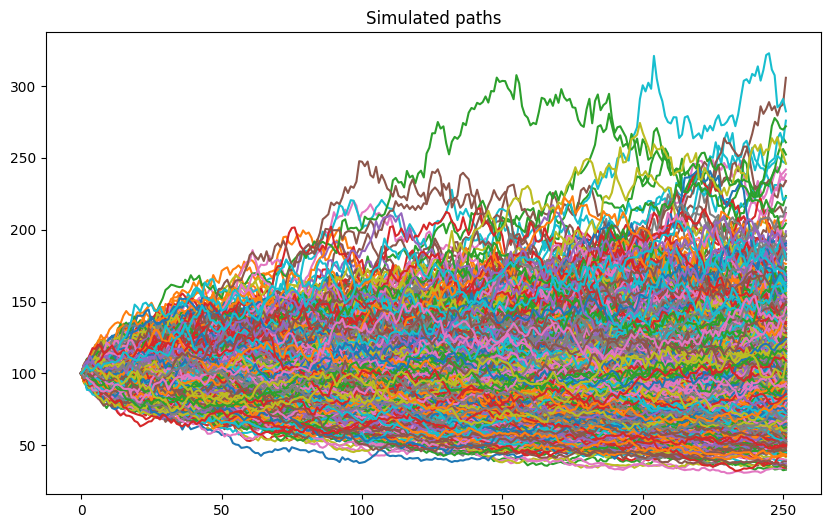

In [7]:
# plot the paths	
plt.figure(figsize=(10, 6))
plt.plot(S.T)
plt.title('Simulated paths')

## Monte Carlo Simulation using pandas

In [8]:
# pandas dataframe 252 days x 1000 paths
random_values = np.random.normal(0, 1, (n, 252))

# Create DataFrame
df = pd.DataFrame(random_values)

# calculate the underlying paths
df = df * volmc + mimc
df = np.exp(df)
df = df.cumprod(axis=1) * S0

## calculate call and put payoff
payoff_call = df.iloc[:,-1].apply(lambda v: max((v - K), 0))
payoff_put = df.iloc[:,-1].apply(lambda v: max((K - v), 0))


<Axes: title={'center': 'Simulated paths'}>

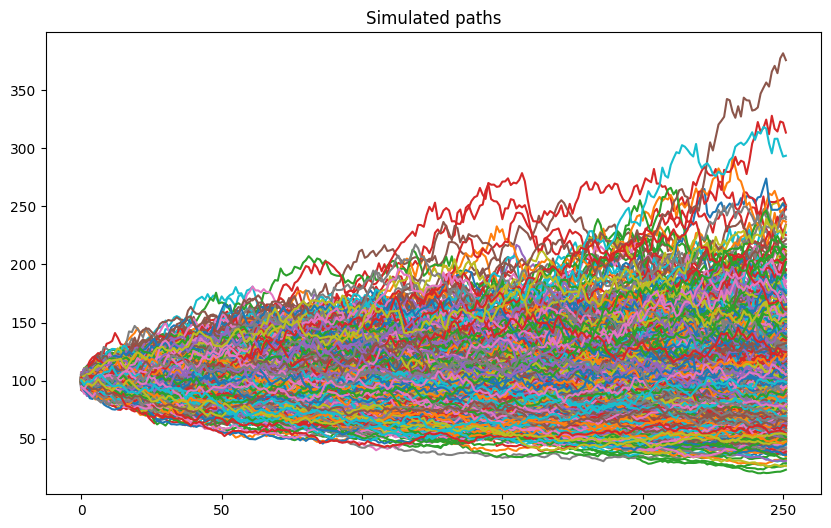

In [9]:
df.T.plot(legend=False, title='Simulated paths', figsize=(10, 6))

## Importing our library

```python
from lib import derivatives as dg
```

In [10]:

from lib import derivatives as dg

# Calculate BS and BSMC
E_ST_bs = S0*np.exp(rf*T)
E_ST_mc = np.mean(df.iloc[:,-1])

# Calculate call option price
call_bs = dg.bs_call_option(S0, K, T, rf, vol)
call_mc = np.mean(payoff_call) * np.exp(-rf * T)

summary = pd.DataFrame({
    'BS': [call_bs, E_ST_bs],
    'MC': [call_mc, E_ST_mc]
}, index=['Call option', 'Expected ST'])

summary


,BS,MC
Call option,15.851942,17.197172
Expected ST,100.000000,102.172689


In [11]:
payoff_call

0      54.935036
1      28.045216
2       0.000000
3       0.000000
4       0.000000
         ...    
995     0.000000
996     5.149719
997     0.000000
998     0.000000
999     0.000000
Name: 251, Length: 1000, dtype: float64

C:\Users\sazevedo\AppData\Local\Temp\ipykernel_27796\4076109572.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  call_path[i] = u_path[i] * norm.cdf((np.log(u_path[i]/K) + mi * t) / (vol * np.sqrt(t)) + (vol * np.sqrt(t))) - (K * np.exp(-rf * t) * norm.cdf((np.log(u_path[i]/K) + mi *t) / (vol * np.sqrt(t))))
C:\Users\sazevedo\AppData\Local\Temp\ipykernel_27796\4076109572.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  hedging_path[i] = (hedging_path[i-1] * np.exp(rf*T/252)) + ((u_path[i] - u_path[i-1]) * np.exp(rf*T/252)) * norm.cdf((np.log(u_path[i-1]/K) + mi*t) / (vol * np.sqrt(t)) + _t)


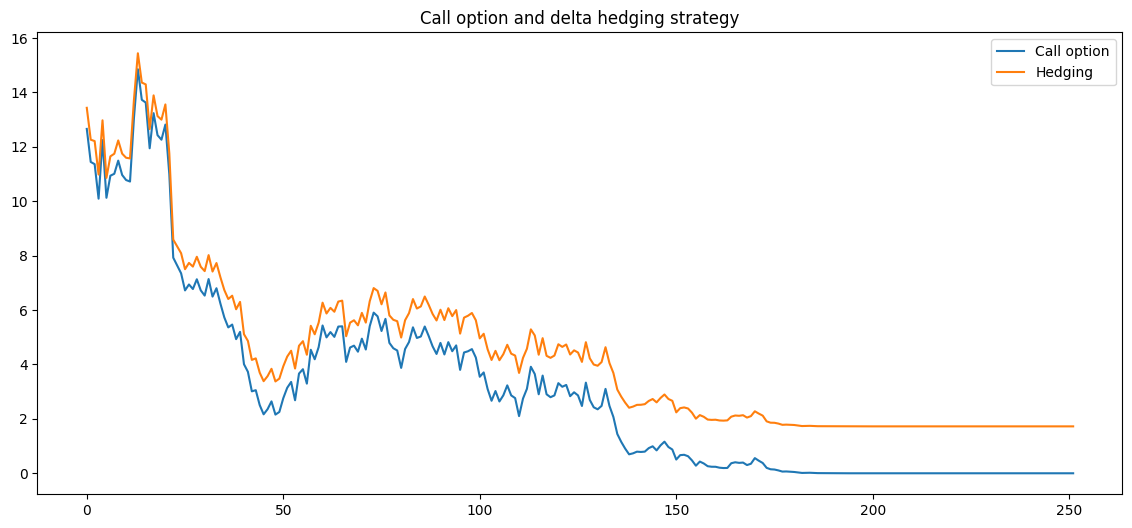

In [12]:
from scipy.stats import norm

# call trajectory calculation
underlying = 10

u_path = df.iloc[underlying]

call_path = pd.Series(index=range(252))
hedging_path = pd.Series(index=range(252))

hedging_path[0] = call_bs * np.exp(rf*T/252) + (u_path[0] - S0 * np.exp(rf*T/ 252)) * norm.cdf((np.log(S0/K) + mi*T) / (vol * np.sqrt(T)))

for i in range(252):
    t = T * (1 - (i+1)/252)
    t2 = T * (1 - (i+54)/252)
    call_path[i] = u_path[i] * norm.cdf((np.log(u_path[i]/K) + mi * t) / (vol * np.sqrt(t)) + (vol * np.sqrt(t))) - (K * np.exp(-rf * t) * norm.cdf((np.log(u_path[i]/K) + mi *t) / (vol * np.sqrt(t))))

    if i > 0:
        _t = (vol * np.sqrt(t2) if i < 150 else (vol * np.sqrt(t)))
        hedging_path[i] = (hedging_path[i-1] * np.exp(rf*T/252)) + ((u_path[i] - u_path[i-1]) * np.exp(rf*T/252)) * norm.cdf((np.log(u_path[i-1]/K) + mi*t) / (vol * np.sqrt(t)) + _t)

# plot the paths
plt.figure(figsize=(14, 6))
plt.plot(call_path, label='Call option')
plt.plot(hedging_path, label='Hedging')
plt.legend()
plt.title('Call option and delta hedging strategy')
plt.show()


Dropdown(description='Select Call path:', index=992, options=(('Path 0', 0), ('Path 1', 1), ('Path 2', 2), ('P…

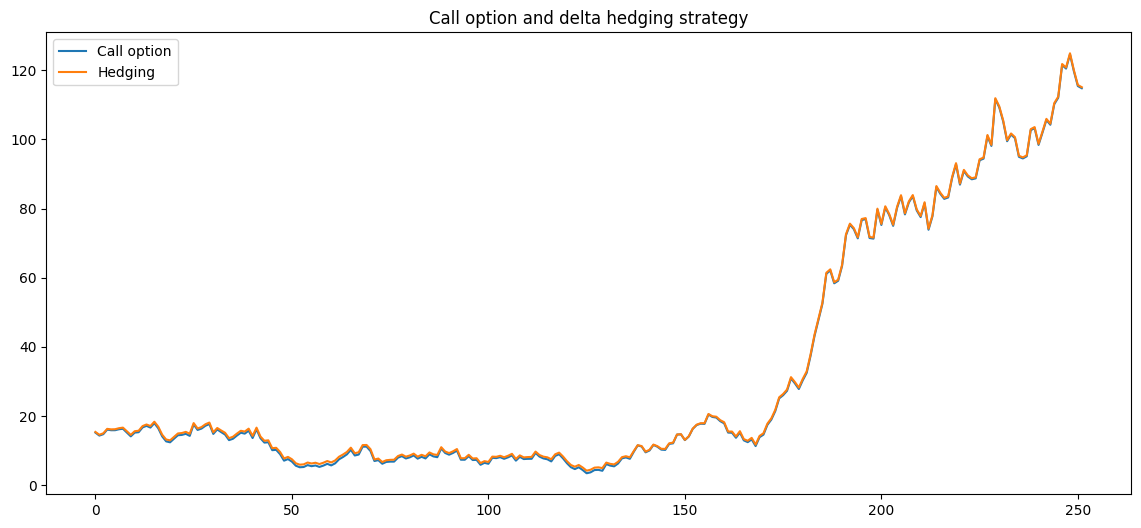

In [13]:
# same procedure using pandas

def calculate_paths(underlying):
    u_path = df.iloc[underlying]

    paths = pd.DataFrame(index=range(252), columns=['Call_path', 'Hedging_path'])
    paths.at[0, 'Hedging_path'] = call_bs * np.exp(rf*T/252) + (u_path[0] - S0 * np.exp(rf*T/ 252)) * norm.cdf((np.log(S0/K) + mi*T) / (vol * np.sqrt(T)))

    for i in range(252):
        t = T * (1 - (i+1)/252)
        t2 = T * (1 - (i+54)/252)
        paths.at[i, 'Call_path'] = u_path[i] * norm.cdf((np.log(u_path[i]/K) + mi * t) / (vol * np.sqrt(t)) + (vol * np.sqrt(t))) - (K * np.exp(-rf * t) * norm.cdf((np.log(u_path[i]/K) + mi *t) / (vol * np.sqrt(t))))

        if i > 0:
            _t = (vol * np.sqrt(t2) if i < 150 else (vol * np.sqrt(t)))
            paths.at[i, 'Hedging_path'] = (paths.at[i-1, 'Hedging_path'] * np.exp(rf*T/252)) + ((u_path[i] - u_path[i-1]) * np.exp(rf*T/252)) * norm.cdf((np.log(u_path[i-1]/K) + mi*t) / (vol * np.sqrt(t)) + _t)

    return paths

# create a dropdown widget to select the underlying
path_selector = widgets.Dropdown(
                    options=[(f'Path {i}', i) for i in range(len(df))],
                    value=10,
                    description='Select Call path:',
                    disabled=False,
                )

# plot the paths
def update_plot(change):
    underlying = path_selector.value
    paths = calculate_paths(underlying)
    clear_output(wait=True)
    display(path_selector)
    plt.figure(figsize=(14, 6))
    plt.plot(paths['Call_path'], label='Call option')
    plt.plot(paths['Hedging_path'], label='Hedging')
    plt.legend()
    plt.title('Call option and delta hedging strategy')
    plt.show()

# attach the update_plot function to the dropdown widget
path_selector.observe(update_plot, names='value')

# display the dropdown widget and the plot
display(path_selector)
update_plot(None)